# lightGBM - histogram-based

- Modified from: https://github.com/meanxai/machine_learning/blob/main/12.LGBM/2.goss.py
- A detailed description of this code can be found in https://youtu.be/N39NE4Nj6vc

In [7]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

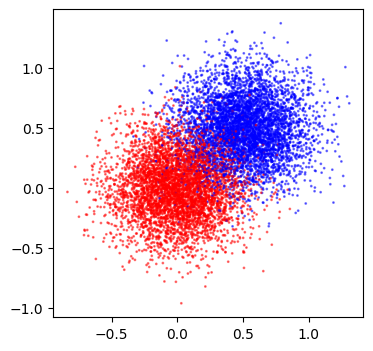

In [8]:
# Create a training dataset
x, y = make_blobs(
    n_samples=10000,
    n_features=2,
    centers=[[0.0, 0.0], [0.5, 0.5]],
    cluster_std=0.25,
    center_box=(-1.0, 1.0),
)

plt.figure(figsize=(4, 4))
color = [["red", "blue"][a] for a in y]
plt.scatter(x[:, 0], x[:, 1], s=1, c=color, alpha=0.5)
plt.show()


In [9]:
n_boost = 50  # the number of boosting
eta = 0.3  # learning rate
max_depth = 2  # max_depth of a tree


def base_model(x, y, weights, F0):
    model = XGBClassifier(
        n_estimators=1,  # just 1 round
        learning_rate=eta,
        max_depth=max_depth,
        max_bin=40,
        tree_method="hist",
        base_score=None,
    )

    # g and h are multiplied by their weights.
    model.fit(x, y, sample_weight=weights, base_margin=F0)
    return model


In [10]:
# Algorithm 2: Gradient-based One-Side Sampling (GOSS)
a = 0.3  # sampling ratio of large gradient data
b = 0.2  # sampling ratio of small gradient data
fact = (1.0 - a) / b
topN = int(a * x.shape[0])
randN = int(b * x.shape[0])
models = []
Fm = np.zeros(y.shape)  # initial prediction in log(odds)

for i in range(n_boost):
    y_prev = 1.0 / (1.0 + np.exp(-Fm))
    g = -(y - y_prev)  # negative residual. first order gradients
    w = np.ones(shape=x.shape[0])  # initial sample weights.
    sorted_g = np.argsort(np.abs(g))[::-1]
    topSet = sorted_g[:topN]
    randSet = np.random.choice(sorted_g[topN:], size=randN, replace=False)
    usedSet = np.hstack([topSet, randSet])
    w[randSet] *= fact  # Assign weight f act to the small gradient data

    newModel = base_model(x[usedSet], y[usedSet], w[usedSet], F0=Fm[usedSet])
    Fm += newModel.predict(x, output_margin=True)
    models.append(newModel)

# Create a test dataset and predict the class of test data
x_test = np.random.uniform(-1.0, 1.5, (1000, 2))

test_Fm = np.zeros(x_test.shape[0])
for model in models:
    test_Fm += model.predict(x_test, output_margin=True)

y_prob = 1.0 / (1.0 + np.exp(-test_Fm))  # log(odds) --> probability
y_pred = (y_prob > 0.5) * 1

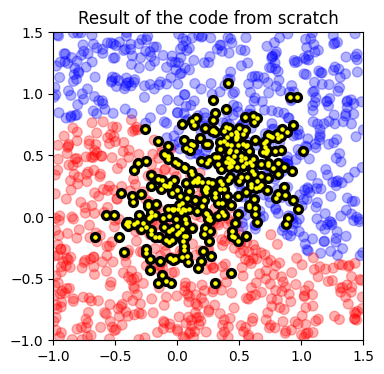

In [11]:
# Check the prediction results and the decision boundary.
def check_result(x, y, x_test, y_pred, title):
    plt.figure(figsize=(4, 4))
    color2 = [["red", "blue"][a] for a in y_pred]
    plt.scatter(x_test[:, 0], x_test[:, 1], s=50, c=color2, alpha=0.3)

    # Only part of the training data is drawn.
    plt.scatter(x[:300, 0], x[:300, 1], s=50, c="black")
    plt.scatter(x[:300, 0], x[:300, 1], s=5, c="yellow")
    plt.xlim(-1.0, 1.5)
    plt.ylim(-1.0, 1.5)
    plt.title(title)
    plt.show()


check_result(x, y, x_test, y_pred, "Result of the code from scratch")

[LightGBM] [Info] Number of positive: 5000, number of negative: 5000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 2
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

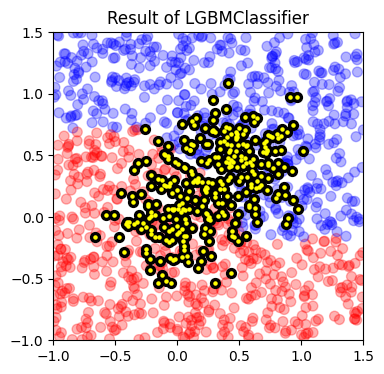

In [12]:
# Use LGBMClassifier library and compare the result from above code
model = LGBMClassifier(
    n_estimators=20,
    max_depth=max_depth,
    learning_rate=eta,
    max_bins=20,
    data_sample_strategy="goss",
    top_rate=0.3,
    other_rate=0.2,
)

model.fit(x, y)
y_pred = model.predict(x_test)
check_result(x, y, x_test, y_pred, "Result of LGBMClassifier")
